Ejercicio 6 - ArcPY Acceso a Datos
==============
_____________________
Esta lista de ejercicios está preparado para realizar pequeñas tareas (scripts) para ser utilizados en ArcGIS. Puede asegurar descargar los datos del archivo "SanFrancisco.zip" de la carpeta de Recursos del Tema 1.

Puede extraer esta carpeta en un directorio como `"C:\Datos\SanFrancisco"`

# 1\. Crear un Script Python


In [ ]:
import arcpy, csv, pandas
busStops = arcpy.GetParameterAsText(0)
censusBlocks2010 = arcpy.GetParameterAsText(1)
censusBlockField = arcpy.GetParameterAsText(2)
csvname = arcpy.GetParameterAsText(3)
headers = arcpy.GetParameterAsText(4).split(',')
sql = arcpy.GetParameterAsText(5)
keyfields = arcpy.GetParameterAsText(6).split(';')
dataDic = {}
censusFields = [ 'BLOCKID10',censusBlockField,'SHAPE@']
if "SHAPE@" not in keyfields:
    keyfields.append("SHAPE@")

arcpy.AddMessage(busStops)
arcpy.AddMessage(censusBlocks2010)
arcpy.AddMessage(censusBlockField)
arcpy.AddMessage(csvname)
arcpy.AddMessage(sql)
arcpy.AddMessage(keyfields)


In [ ]:
x = 0
with arcpy.da.SearchCursor(busStops, keyfields, sql) as cursor:
    for row in cursor:
        stopid = x
        shape = row[-1]
        dataDic[stopid] = []
        dataDic[stopid].append(shape.buffer(400))
        dataDic[stopid].extend(row[:-1])
        x+=1
         


In [ ]:
processedDataDic = {}
for stopid in dataDic.keys():
    values = dataDic[stopid]
    busStopBuffer = values[0]
    blocksIntersected = []
    with arcpy.da.SearchCursor(censusBlocks2010, censusFields) as cursor:
        for row in cursor:
            block = row[-1]
            population = row[1]
            blockid = row[0]            

            if busStopBuffer.overlaps(block) ==True:
                interPoly = busStopBuffer.intersect(block,4)
                data = population,interPoly, block
                blocksIntersected.append(data)
    processedDataDic[stopid] = values, blocksIntersected    

In [ ]:
dataList = []
for stopid in processedDataDic.keys():
    allValues = processedDataDic[stopid]
    popValues = []
    blocksIntersected = allValues[-1]
    for blocks in blocksIntersected:
        pop = blocks[0]
        totalArea = blocks[-1].area
        interArea = blocks[-2].area
        finalPop = pop * (interArea/totalArea)
        popValues.append(finalPop)
    averagePop = round(sum(popValues)/len(popValues),2)
    busStopLine = allValues[0][1]
    busStopID = stopid
    finalData = busStopLine, busStopID, averagePop
    dataList.append(finalData)


In [ ]:
def createCSV(data, csvname, mode ='ab'):
    with open(csvname, mode) as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',')
        csvwriter.writerow(data)
             
headers.insert(0,"ID")
createCSV(headers, csvname, 'wb')     
for data in dataList:
    createCSV(data, csvname)

# 2\. Crear un Script Tool



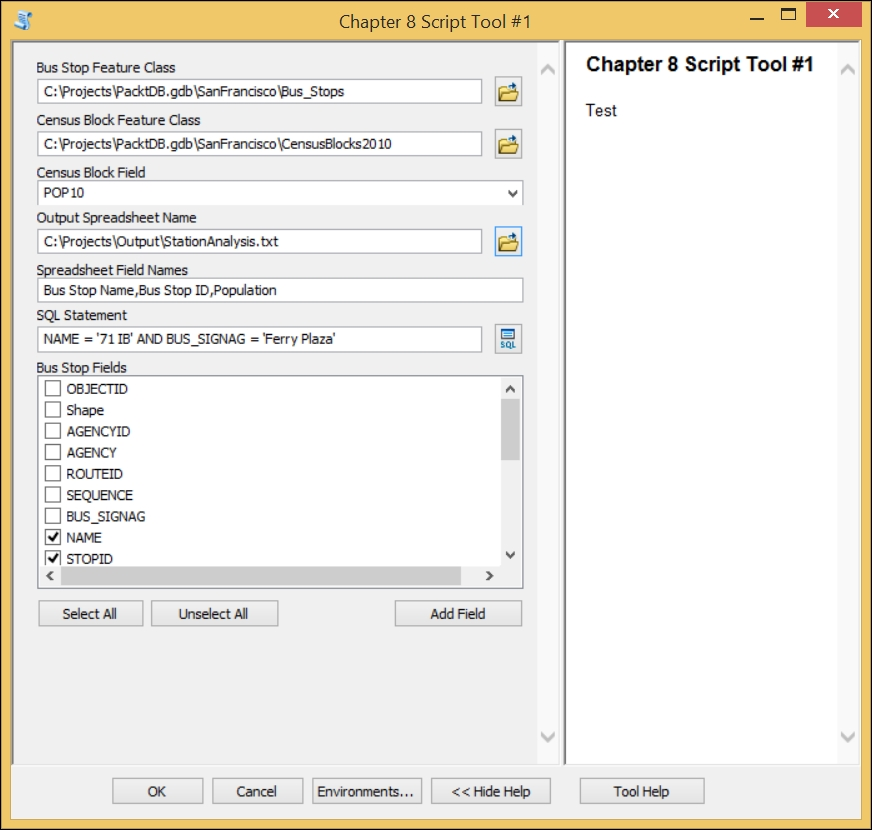